# Fitting Generalized Linear Models (GLMs) on neural data from hippocampus

In this tutorial, we will fit Generalized Linear Models (GLMs) to data from neurons recorded in hippocampus.

(TODO add some details about the dataset)

Adapted from https://github.com/pillowlab/GLMspiketraintutorial_python/blob/main/tutorial1_PoissonGLM.ipynb

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cebra
import cebra.datasets
from scipy.io import loadmat
import scipy.linalg

## Data loading

In [1]:
from week5_utils import HippocampusDataset


data = HippocampusDataset()
data.all_spikes_binned.shape, data.position.shape, data.num_neurons

((10178, 120), (10178,), 120)

### Data exploration

To explore the dataset, we plot the tuning curves (at which point in location does each neuron fire?) for all 120 neurons in the dataset

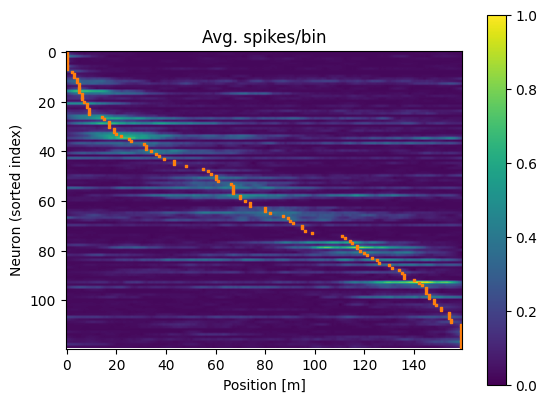

In [10]:
import scipy.signal

stim = data.position
neural = data.all_spikes_binned

counts, bins = np.histogram(stim, bins = 160, range = (0,1.6))
stim_bin_idx = np.digitize(stim, bins, right = False) - 1

avg = np.zeros((160, 120))
for i in range(160):
    avg[i, :] = neural[stim_bin_idx==i,:].mean(0)

avg = scipy.signal.savgol_filter(avg, axis = 0, window_length=11, polyorder=2)

max_bin = avg.argmax(axis = 0)
neuron_index = np.argsort(max_bin)

plt.title("Avg. spikes/bin")
plt.imshow(avg[:, neuron_index].T)
plt.scatter(max_bin[neuron_index], np.arange(120), marker='s', c = 'C1', s = 1)
plt.colorbar()
plt.xlabel("Position [m]")
plt.ylabel("Neuron (sorted index)")
plt.show()

## Data Visualization

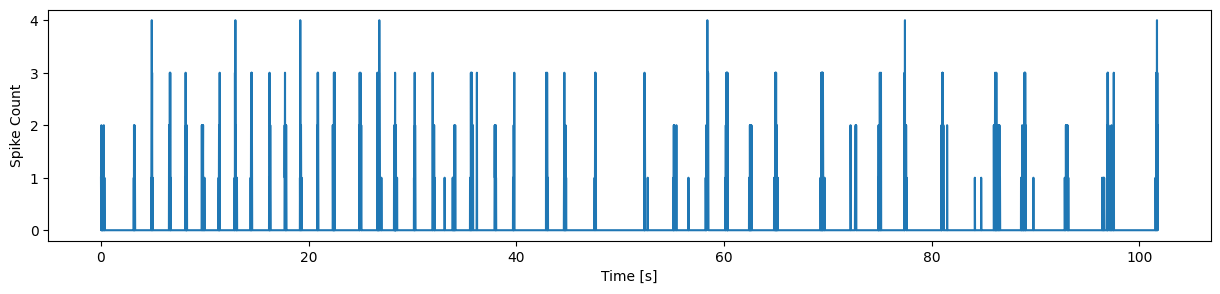

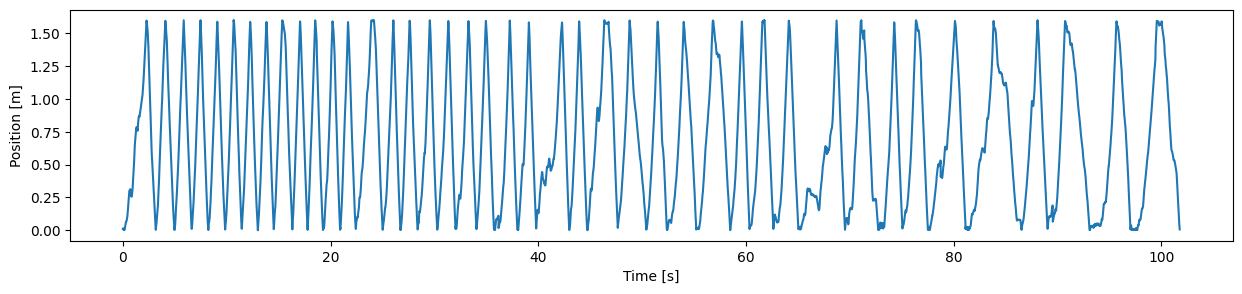

In [11]:
plt.figure(figsize=(15,3))
plt.plot(data.time, data.get_neuron_spikes(51))
plt.xlabel("Time [s]")
plt.ylabel("Spike Count")
plt.show()

plt.figure(figsize=(15,3))
plt.plot(data.time, data.position)
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.show()

## Design matrix

... TODO ...

**Exercise:** Complete the `build_design_matrix` function.

<Figure size 1200x800 with 0 Axes>

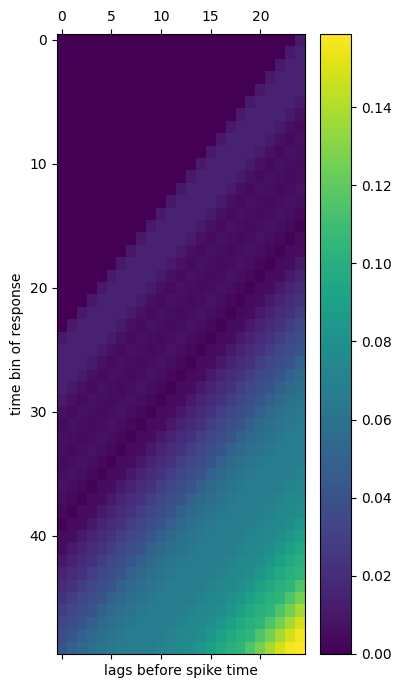

In [12]:
def build_design_matrix(filter_size):
    """Exercise: Build the design matrix manually."""
    padded_stim = np.pad(stim, (filter_size-1,0), mode = "constant", constant_values = 0.)
    design_mat = np.zeros((len(data),filter_size))
    for j in np.arange(len(data)):
        design_mat[j] = padded_stim[j:j+filter_size] # grab last 'nkt' bins of stmiulus and insert into this row
    return design_mat

def build_design_matrix_ref(filter_size):
    """For reference, this is a fast way to build the design matrix."""
    padded_stim = np.hstack((np.zeros(filter_size-1), stim))   # pad early bins of stimulus with zero
    design_mat = scipy.linalg.hankel(padded_stim[:-filter_size+1], stim[-filter_size:])
    return design_mat


filter_size = 25
design_mat = build_design_matrix(filter_size=filter_size)
design_mat_ref = build_design_matrix_ref(filter_size=filter_size)

# Check that the matrix construction is correct!
assert design_mat.shape == (stim.shape[0], filter_size)
assert np.allclose(design_mat, design_mat_ref)
    
plt.figure(figsize=[12,8])
plt.matshow(design_mat[:50], aspect='auto')
plt.xlabel('lags before spike time')
plt.ylabel('time bin of response')
plt.colorbar()
plt.show();

Visualization of the spike counts (top) and regressors we will fit the GLM with:

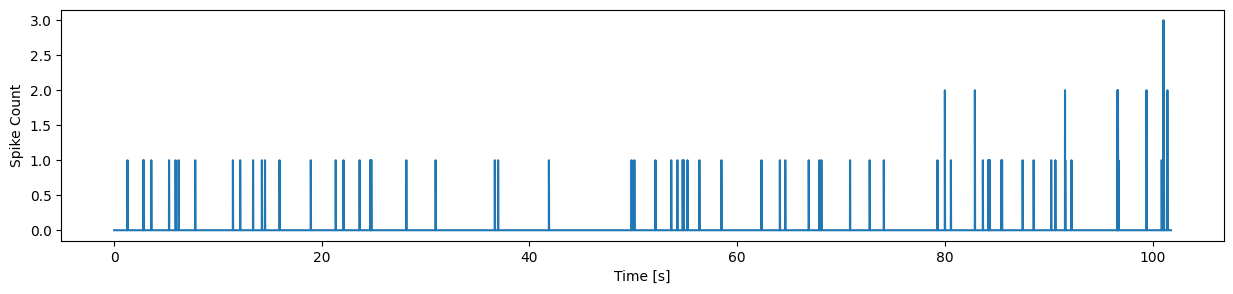

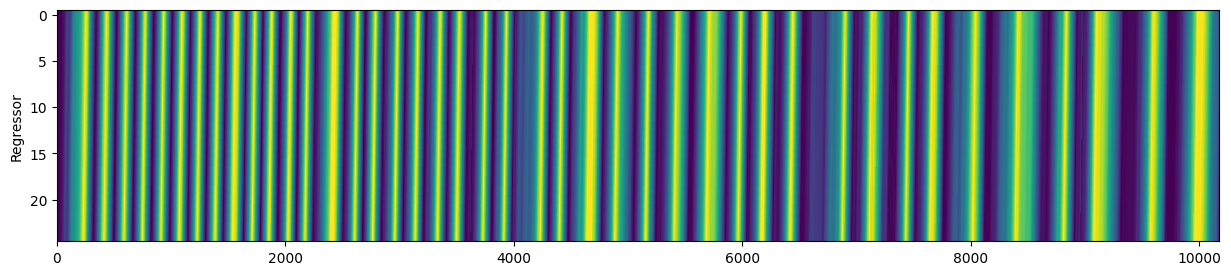

In [13]:
filter_size = 25
design_mat = build_design_matrix(filter_size=filter_size)

plt.figure(figsize=(15,3))
plt.plot(data.time, neural[:,30])
plt.xlabel("Time [s]")
plt.ylabel("Spike Count")
plt.show()

plt.figure(figsize=(15,3))
plt.imshow(design_mat.T, aspect = "auto", interpolation="none")
plt.ylabel("Regressor")
plt.show()

## GLM fitting with `statsmodels`

We will now fit GLMs using the `statsmodels` python library. The documentation can be found here: https://www.statsmodels.org/stable/glm.html

The components of the GLM are:
- the input variables: This is the design matrix we constructed in the previous step. The input has shape `timesteps, num_regressors`. The variables are also called *exogenous* variables, and abbreviated as `exog` in `statsmodels`.
- the output variables we would like to model: These are the binned spiking rates of the neuron we would like to fit. The output has shape `timesteps,` in our case (it is also possible to fit multivariate outputs, but we won't cover this during this tutorial). These variables are also called *endogenous* variables, and abbreviated as `endog` in `statsmodels`.
- the distribution to model, and the corresponding link function. In our case, we would like to fit a Poisson variable, and use a `log` link function. More details [here](https://www.statsmodels.org/stable/generated/statsmodels.genmod.families.family.Poisson.html#statsmodels.genmod.families.family.Poisson).

In [14]:
import statsmodels.api as sm

class GLMModel():
    """The class for our GLM model.
    
    We split the functionality into different parts:
    - fitting the model
    - computing the goodness of fit (the pseudo-R2)
    - making predictions on the dataset
    """

    def __init__(self):
        self.link_function = sm.families.links.Log()
        self.family = sm.families.Poisson(link = self.link_function)

    def fit(self, design_matrix, spikes):
        design_mat_offset = np.hstack((np.ones((len(design_matrix),1)), design_matrix))
        self._model = sm.GLM(
            endog=spikes,
            exog=design_mat_offset,
            family=self.family
        )
        self._results = self._model.fit(max_iter=100, tol=1e-6, tol_criterion='params')

    def predict(self, design_mat):
        return np.exp(self.constant_params + design_mat @ self.filter_params)

    def score(self):
        return self._results.pseudo_rsquared(kind='mcf') 

    @property
    def filter_params(self):
        return self._results.params[1:]

    @property
    def constant_params(self):
        return self._results.params[0]


glm = GLMModel()
glm.fit(design_mat, data.get_neuron_spikes(51))
print("Score", glm.score())

Score 0.4702026044553036


We can now fit GLMs on the full dataset!

In [15]:
import tqdm

prediction = np.zeros_like(data.all_spikes_binned)
filters = []
r2 = np.zeros(neural.shape[1])

r2[:] = float("nan")
prediction[:] = float("nan")

glm = GLMModel()

for neuron_id in tqdm.tqdm(range(data.num_neurons)):
    try:
        glm.fit(design_mat, data.get_neuron_spikes(neuron_id))
    except ValueError:
        print(f"Error fitting neuron {neuron_id}. Skipping")
        continue
    r2[neuron_id] = glm.score()
    prediction[:,neuron_id] = glm.predict(design_mat)

 32%|███▎      | 39/120 [00:13<01:08,  1.19it/s]/Users/steffen.schneider/.pyenv/versions/3.10.13/envs/cebra/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
 34%|███▍      | 41/120 [00:13<00:38,  2.07it/s]

Error fitting neuron 39. Skipping


100%|██████████| 120/120 [00:46<00:00,  2.57it/s]


### Results overview (histogram of pseudo-R2 values)

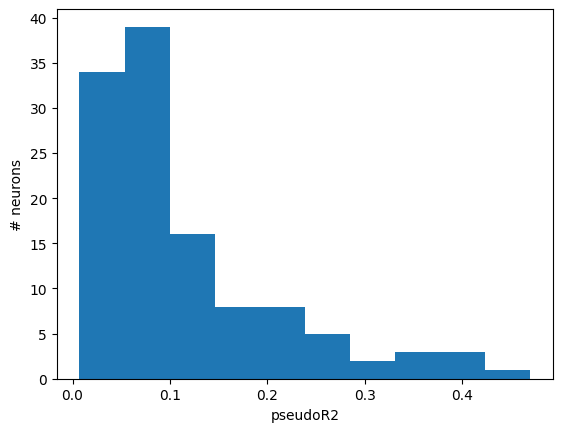

In [16]:
plt.hist(r2)
plt.ylabel("# neurons")
plt.xlabel("pseudoR2")
plt.show()

Next, we visualize the predictions for the 10 best-fitted and the 10 worst-fitted neurons.

#### Best 10 fits

51


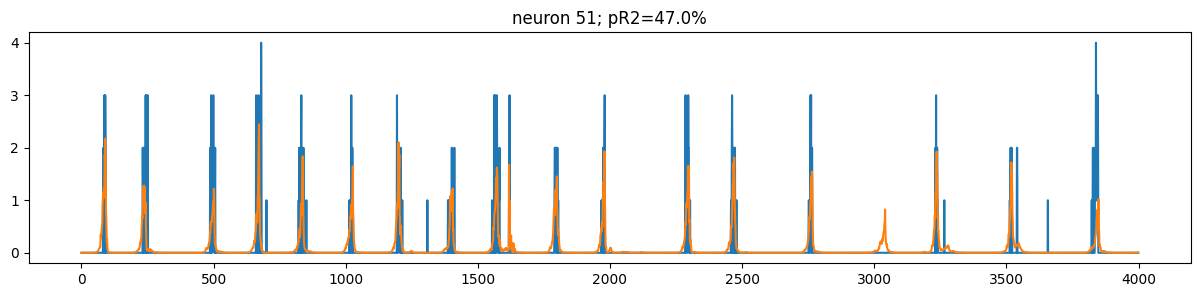

84


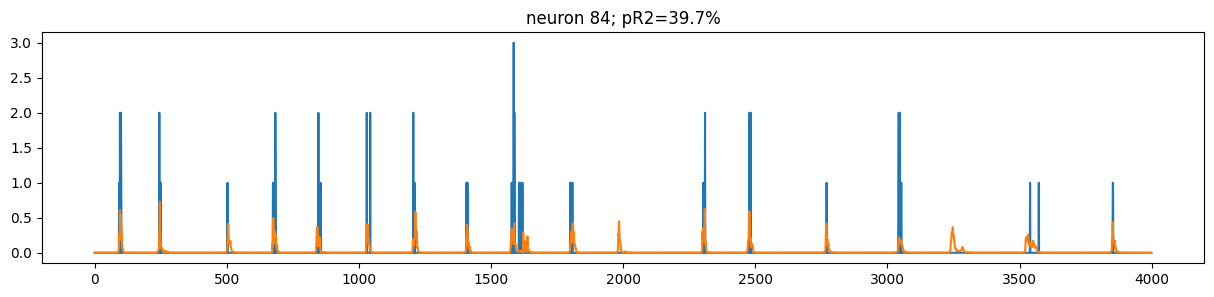

40


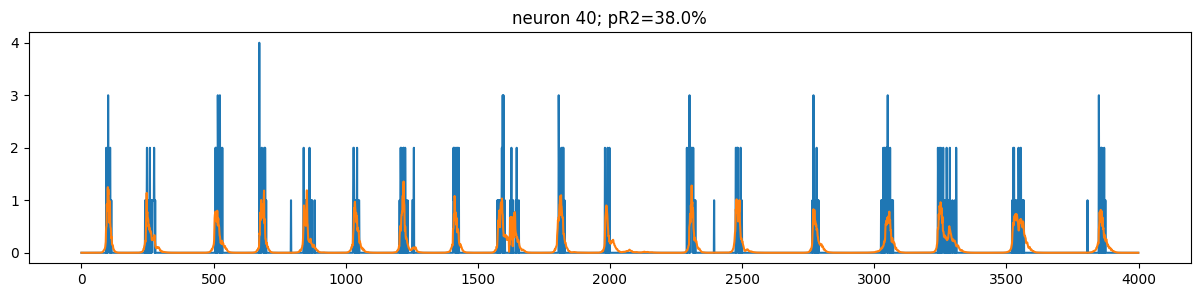

83


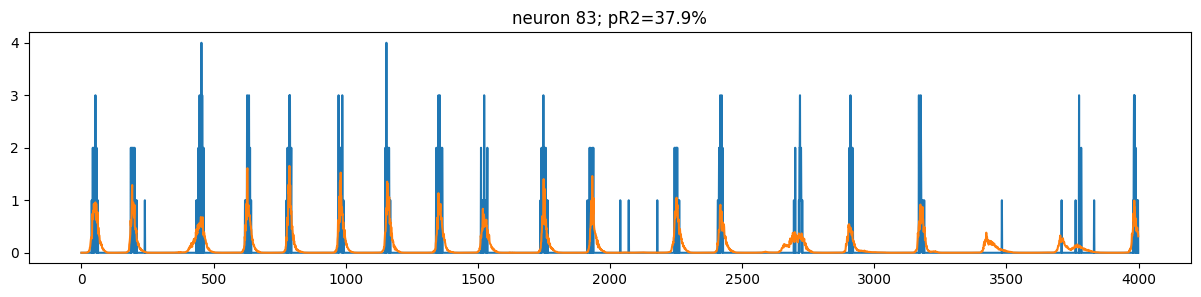

76


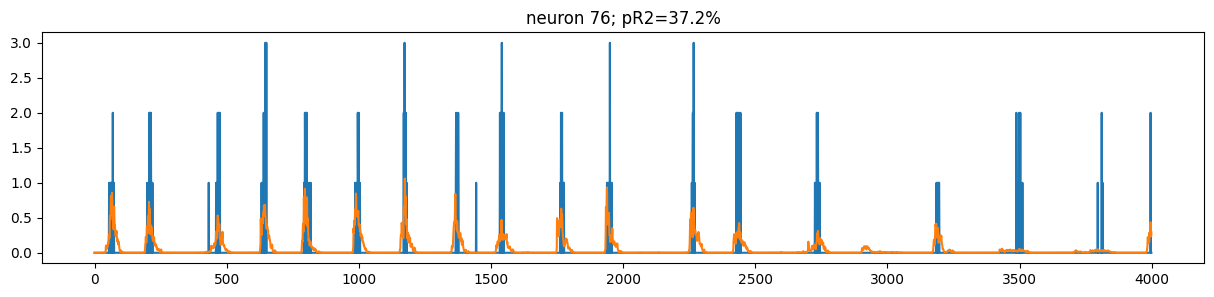

24


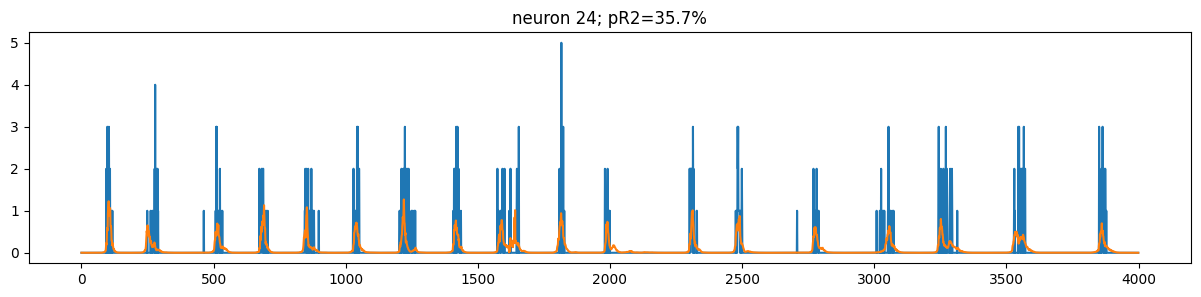

94


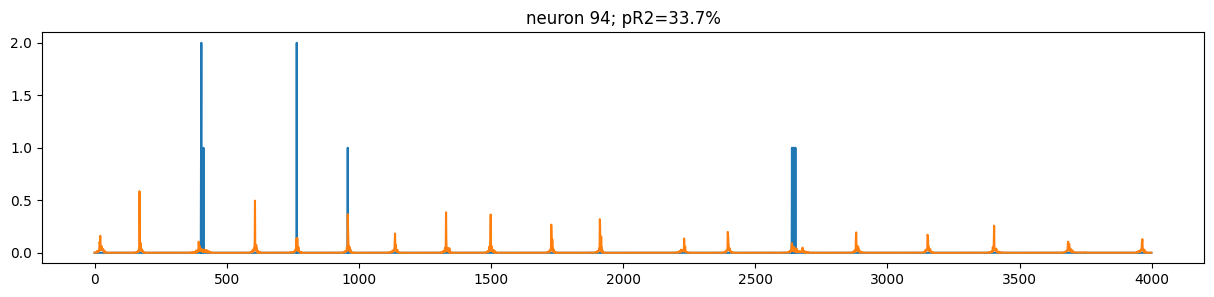

66


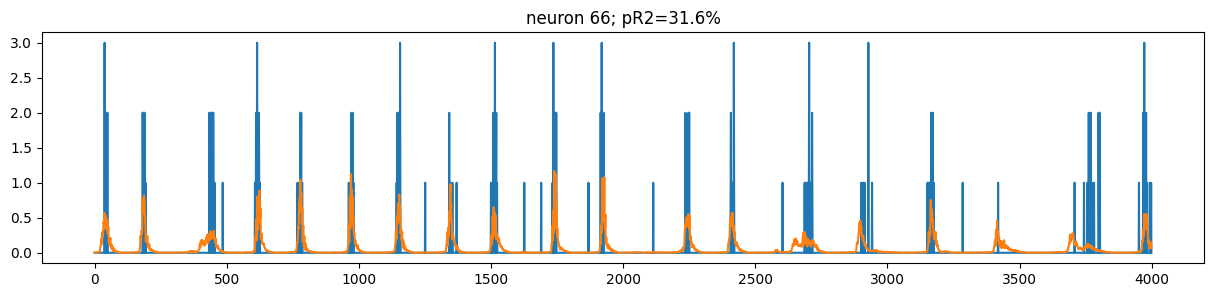

77


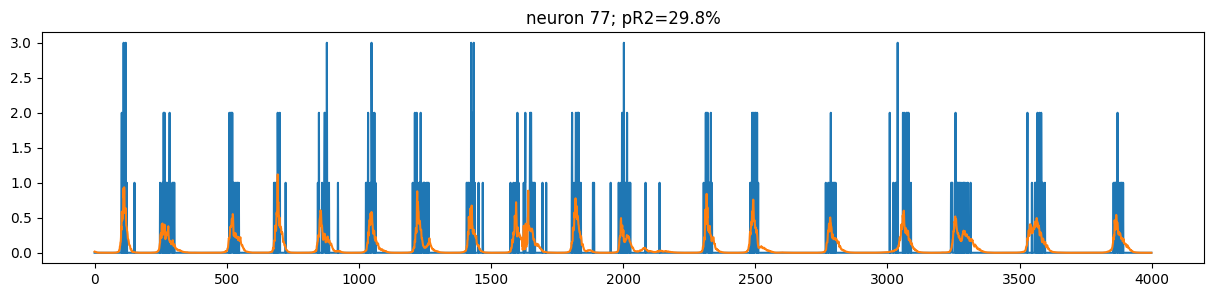

46


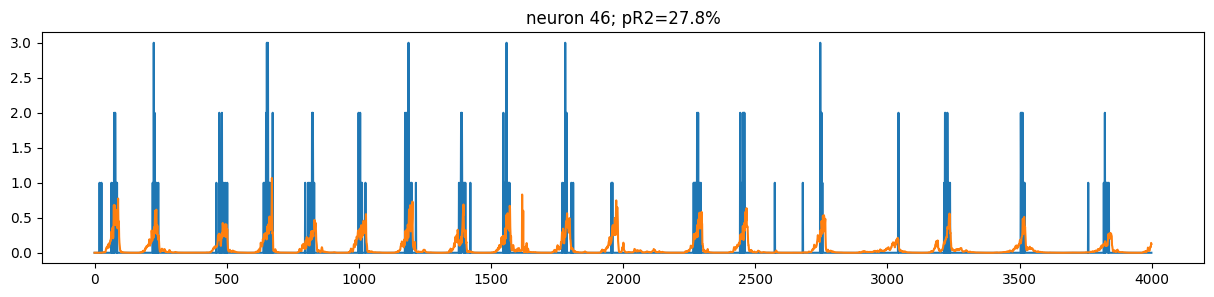

In [17]:
for neuron_id in np.argsort(-r2)[:10]:
    print(neuron_id)
    binned_spikes = data.get_neuron_spikes(neuron_id) 
    plt.figure(figsize=(15,3))
    plt.plot(binned_spikes[2000:6000])
    plt.plot(prediction[2000:6000,neuron_id])
    plt.title(f"neuron {neuron_id}; pR2={r2[neuron_id]*100:.1f}%")
    plt.show()

#### Worst 10 fits

14


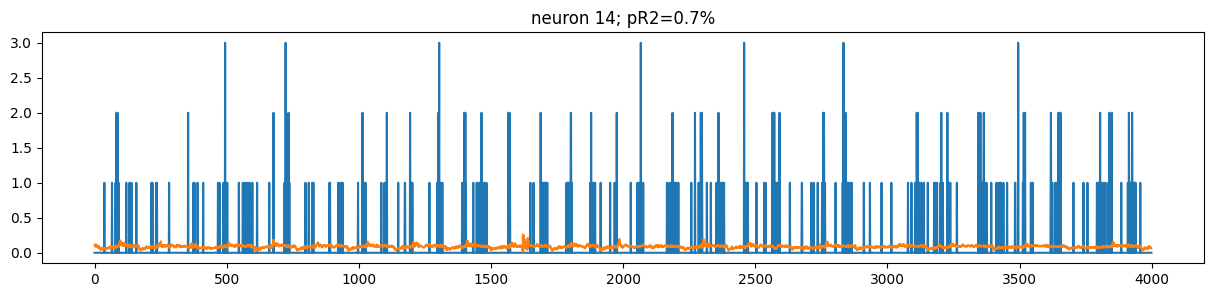

16


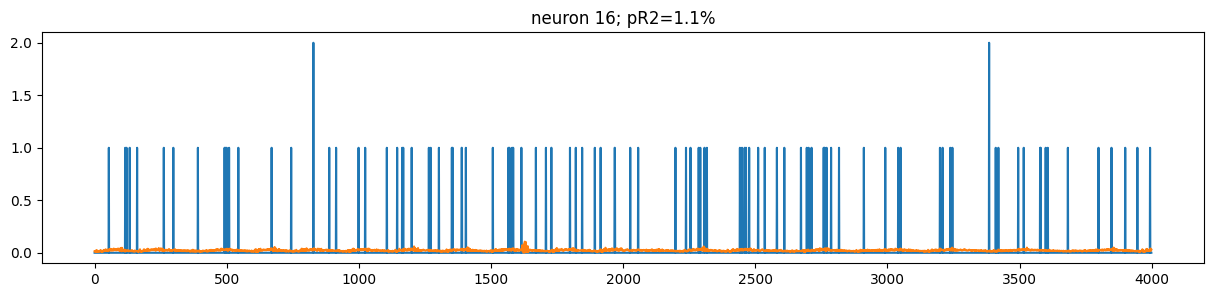

34


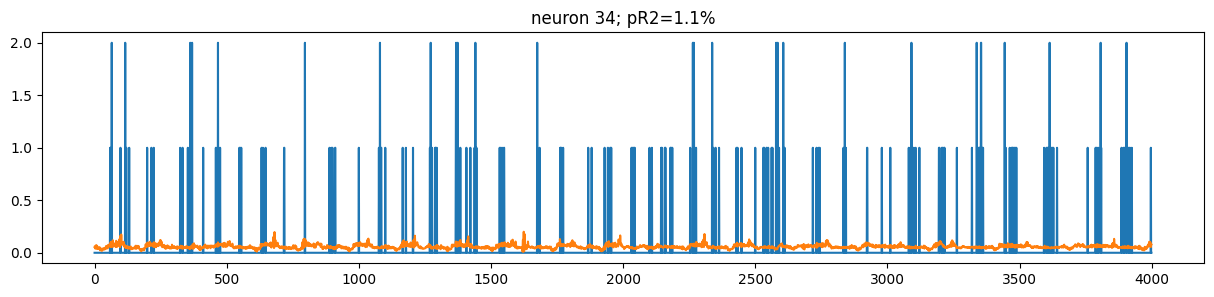

110


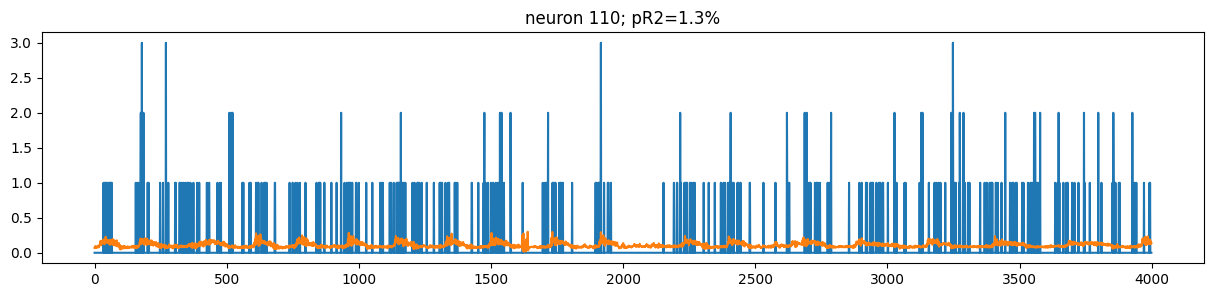

104


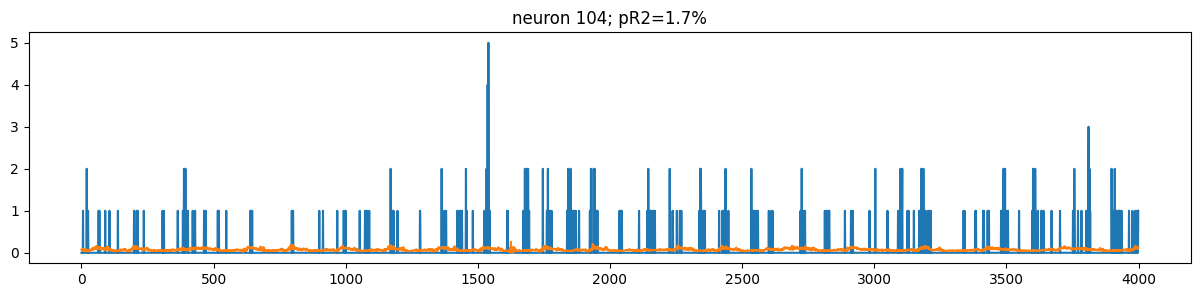

20


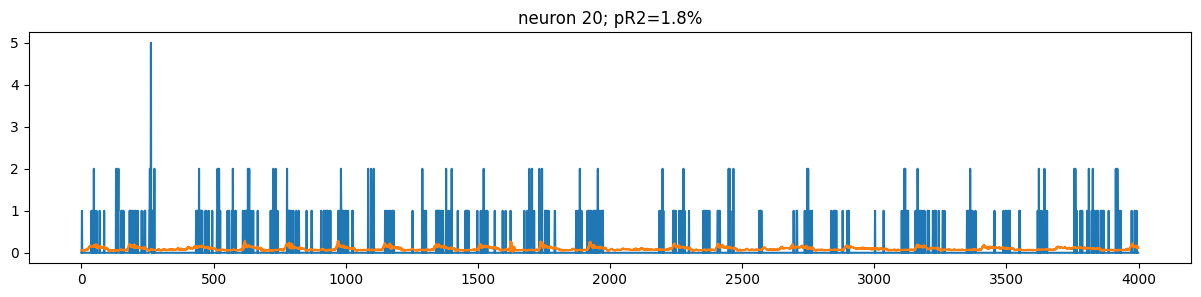

55


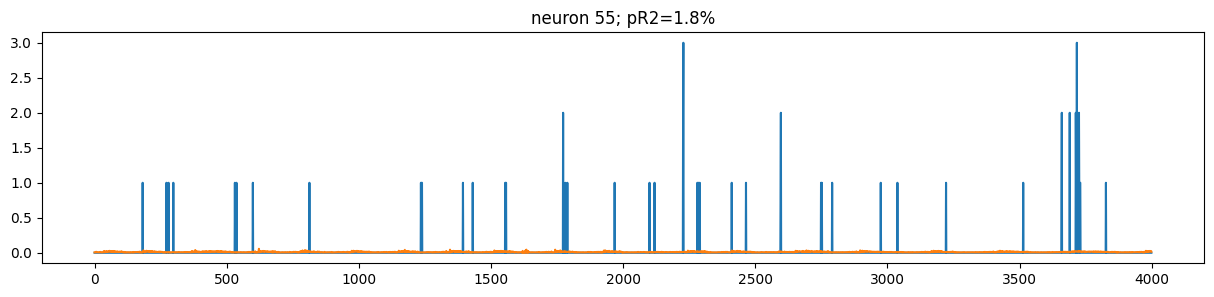

60


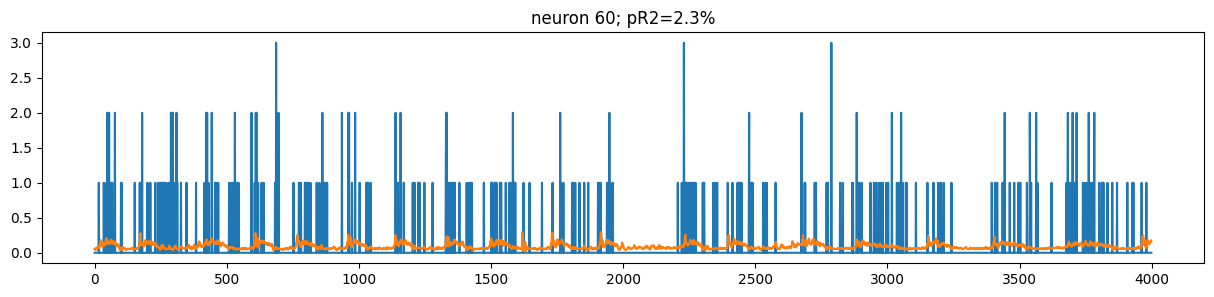

58


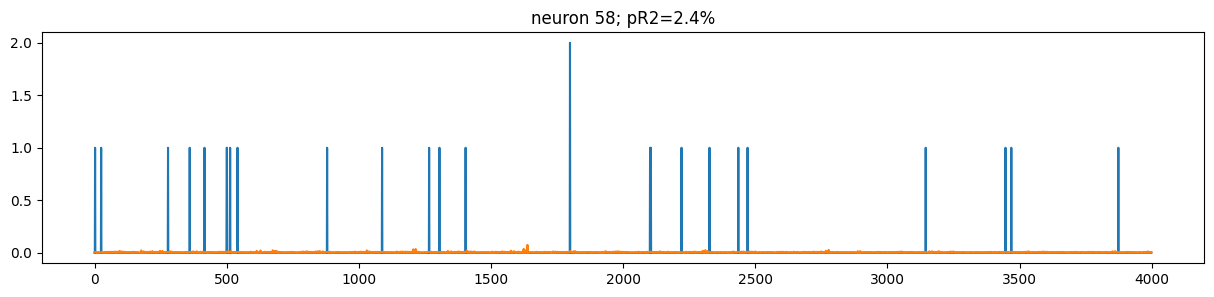

1


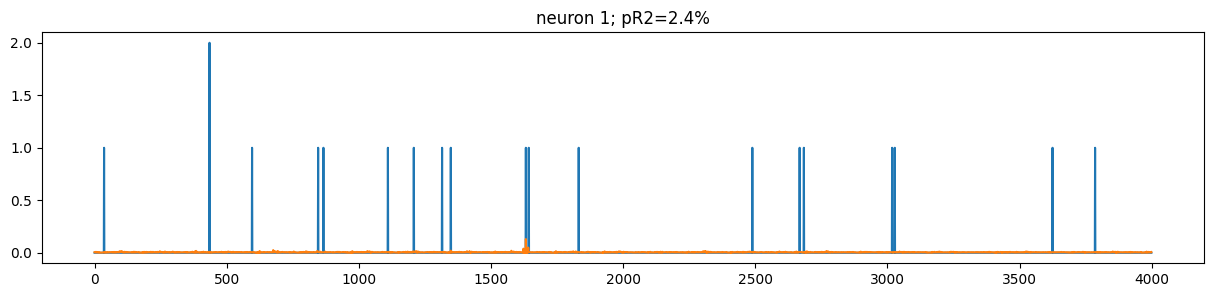

In [18]:
for neuron_id in np.argsort(r2)[:10]:
    print(neuron_id)
    binned_spikes = data.get_neuron_spikes(neuron_id) 
    plt.figure(figsize=(15,3))
    plt.plot(binned_spikes[2000:6000])
    plt.plot(prediction[2000:6000,neuron_id])
    plt.title(f"neuron {neuron_id}; pR2={r2[neuron_id]*100:.1f}%")
    plt.show()